<a href="https://colab.research.google.com/github/Raahim58/Neural-networks/blob/main/01_micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. Building MicroGrad from scratch

**Resources:**

* micrograd github repo: https://github.com/karpathy/micrograd

* tutorial lecture 1 (micrograd) code: https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/micrograd

* link to youtube lecture 1: https://youtu.be/VMj-3S1tku0?si=Yau2S56U0ghVKuMF

* whole lecture series code: https://github.com/karpathy/nn-zero-to-hero






## 0. Running down the basics

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

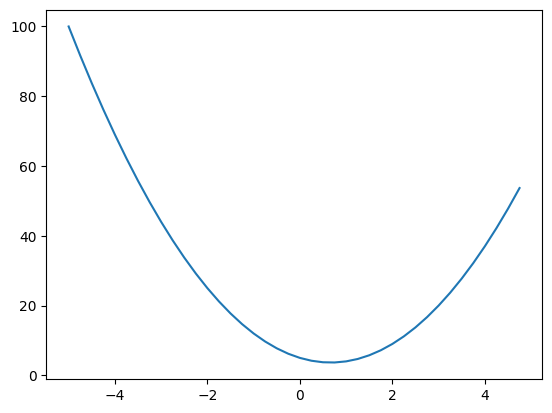

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys);

## 1. Finding derivatives of a simple function

Not taking the symbolic approach to deriving the derivative as that contains thousands of lines of codes and joining a lot of neural nets.

Derivative: slope of a function when the value is tweaked by a small **h**

### 1.1 Derivative of a simple function with one input

* Derivative of a function will be 0 at some precise point.
* The function does not respond at a particular value - does not change

In [ ]:
# Tweaking the function by a small value h
h = 0.0001
x = 3.0 # for this function df/dx = 0 at x = 2/3
(f(x + h) - f(x))/h # rise/run

14.000300000063248

### 1.2 Derivative of a simple function with multiple inputs

In [ ]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


Looking at the derivative of d w.r.t a, b and c.

In [ ]:
h = 0.0001

# inputs

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print("with a as input:\n")
print("d1: ", d1)
print("d2: ", d2)
print("slope: ", (d2-d1)/h) # finding out the slope when d1 is tweaked by a small value h, and this is normalized by h


with a as input:

d1:  4.0
d2:  3.999699999999999
slope:  -3.000000000010772


In [ ]:
# doing the same with b as the input

h = 0.0001

# inputs

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print("with b as input:\n")
print("d1: ", d1)
print("d2: ", d2)
print("slope: ", (d2-d1)/h)


with b as input:

d1:  4.0
d2:  4.0002
slope:  2.0000000000042206


In [ ]:
# doing the same with c as the input

h = 0.0001

# inputs

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print("with c as input:\n")
print("d1: ", d1)
print("d2: ", d2)
print("slope: ", (d2-d1)/h)

with c as input:

d1:  4.0
d2:  4.0001
slope:  0.9999999999976694


## 2. Building Value object of micrograd

Available on the code link

### 2.1 Creating a class

Recreating the expression/Data Structure above progmatically

* `_children` is used to get the previous values being evaluated in the expression -> `(variable)._prev` to get the desired output.
* `repr` is used to prints out things nicely.
* `add` and `mul` are needed as Python can't add 2 `Value` objects.
* `_op` is used to recall the function that was used between the `children` values to get the output.
* `label` to see which variables are where.
* `grad` maintains the derivative of output node (L) w.r.t that value (leaf node) -> 0 refers to no effect
  * at initialization we are assuming that none of the values effect the output value

In [ ]:
class Value:
  def __init__(self, data, _children = (), _op = '', label = ''): # 'children' is originally a Tuple here
    self.data = data
    self._prev = set(_children) # converted to a set to maintain efficiency
    self._op = _op
    self.label = label
    self.grad = 0.0 # initially 0

  # Providing a way for the expression to be printed out cleanly
  def __repr__(self):
    return f"Value(data = {self.data})"

  # Python can't add 2 Value's objects so we have to define it ('a+b' won't work)
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out # Python internally calls `a.__add__(b)`

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c) = a*b + c
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L' # output of our graph
L
print(f"Printing out the children of 'L': {L._prev}")
print(f"Printing out the operation between the children for outputting 'L': {L._op}")

Printing out the children of 'L': {Value(data = -2.0), Value(data = 4.0)}
Printing out the operation between the children for outputting 'L': *


### 2.2 Visualizing the expression

* Creates a new function `draw_dot()` which you can call on some root node, and then it visualizes it through `graphviz`, an open source software which helps build graph through its API.
* Building a mathematical expression through `add` and `mul` so far. They are scalar valued along the way and we can do a forward pass to build out the expression to bring a single output L.
* Run back propogation and calculate the gradient after calculating the expression through the forward pass. That will entail calculating the gradient of the output w.r.t to all hidden variables/leaf nodes/weights of the neural net, and the inputs (e.g `dL/df, dL/de, , dL/dd, dL/dc, dL/db, dL/da`) -> some of these will eventually represent the weights of a neural net so we will need to know eventually how those weights are impacting the loss function.
  * We'll be majorly interested in the derivative of the output w.r.t to the leaf nodes rather than the data (input nodes) as the data is fixed;
  * The weights will be iterated on using the gradient information.

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

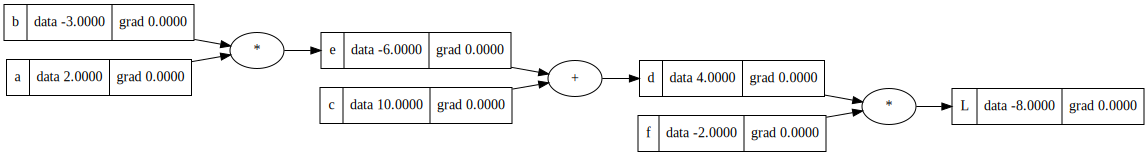

In [ ]:
draw_dot(L)

## 3. Performing backpropogation manually

### 3.1 Example 1: A simple expression

* We have to apply chain rule piece by piece, iterating through each node and apply it locally.
* We recursively multiply the local derivatives.
* Backpropogation is essentially the recursive application of chain rule backward through the computation of graph.

```
L = d * f
dL/dd = ? -> f
(f(x+h)-f(x))/h
((d+h)*f - d*f)/h
(d*f + h*f - d*f)/h
(h*f)/h
f
```

In [ ]:
import math

class Value:
  def __init__(self, data, _children = (), _op = '', label = ''): # 'children' is originally a Tuple here
    self.data = data
    self._prev = set(_children) # converted to a set to maintain efficiency
    self._op = _op
    self.label = label
    self.grad = 0.0 # initially 0

  # Providing a way for the expression to be printed out cleanly
  def __repr__(self):
    return f"Value(data = {self.data})"

  # Python can't add 2 Value's objects so we have to define it ('a+b' won't work)
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out # Python internally calls `a.__add__(b)`

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c) = a*b + c
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L' # output of our graph
L
# print(f"Printing out the children of 'L': {L._prev}")
# print(f"Printing out the operation between the children for outputting 'L': {L._op}")

Value(data = -8.0)

In [ ]:
def lol():

  h = 0.001

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f; L.label = 'L' # output of our graph
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  b.data += h
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f; L.label = 'L' # output of our graph
  L2 = L.data # L is a value node so we want its data

  print((L2 - L1)/h) # rise/run

lol()

-3.9999999999995595


Continuing our backpropogation manually, we now need to drive the crux of our gradient inline manual check by deriving gradients of node **c and e**:

```
dL/dc & dL/de
```

What is `dd/dc`? -> 1.0
* By symmtery `dd/de` will also be 1.0

```
d = c + e
(f(x+h) - f(x))/h
((c*h + e) - (c+e))/h
(c + h + e - c - e)/h
h/h
1.0
```
* But these are the local derivatives, we want the global one's which are backpropogating two nodes from L rather than just one from `d` or `f`
* the whole `+` node is meant to be embedded inside a massive graph; we know how L impact d, and we now know how **c and e impact d** -> we put this together by the chain rule.
* ***chain rule:*** when a variable x is dependent on a variable y which is dependent on a variable z, which makes x dependent on z as well.

```
dd / dc = 1.0
dd / de = 1.0
d = c + e

dL / dd # Know as -2.0
dd / dc # Know as 1.0
dL/dc = (dL / dd) * (dd / dc) # Want by chain rule
```

Manually backpropogating to get our data nodes **a and b:**

```
dL / de = -2.0
e = a + b
de / da ? -> b
de / db ? -> a

* dL / da = (dL / de) * (de / da) -> (dL / de) * (b)

* dL / db = (dL / de) * (de / db) -> (dL / de) * (a)
```

In [ ]:
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
e.grad = -2.0
d.grad = -2.0
f.grad = 4.0
L.grad = 1.0

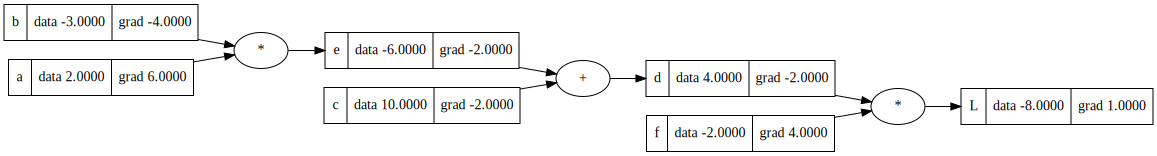

In [ ]:
draw_dot(L)

Previewing a single optimization step

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

# Forward pass where f remains unchanged
e = a * b
d = e + c
L = d * f

print(L.data) # We nudged the values in direction of the gradients so we expect the value to be positive

-7.4352


### 3.2 Example 2: A neuron

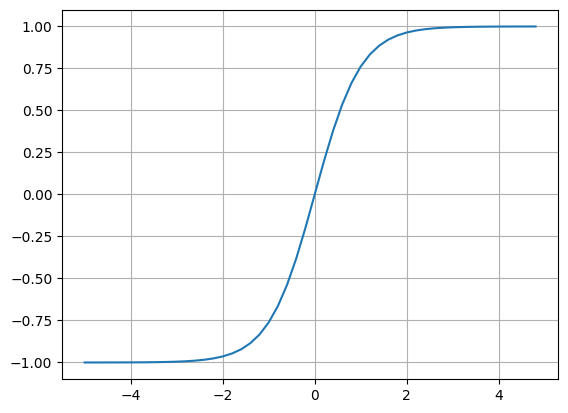

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid();

```
x1*w1 + x2*w2 + b
```
* implementing this but in small steps so that we have pointers to all these intermediate notes
* `n` is the cell body wall activation without the activation function (for now)
* `tanh` is the activation function (hyperbolic one) -> have to implement exponentiality in it so we implement it in the class function.

In [ ]:
# inputs x1,x2 (2D neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2 (synaptics strings for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'


In [ ]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

```
o = tanh(n)
do/dn = 1 - tanh(n)**2 -> 1 - o**2
```

* While an addition `+` operator is being applied in backpropogation, the grad values flow equally so each input gets the value from the output node, like `b` and `x1w1 + x2w2` get the value of `n` as **0.5**.
* If we want an output of a neuron to increase, then the influence on these expressions is a positive contribution to the output.
* If it being multiplied `*` during backpropogation, using chain rule: the gradient is the data value * the node from which you're backprogating from ->
```
x2.grad = w2.data * x2w2.grad
```
* derivative tells us the influence of this node on the final output
* if we want the neuron's output to increase, w2 doesn't matter to this neuron's output as it is 0 but w1 does so it should go up (positive) for the output to be positive or go up.

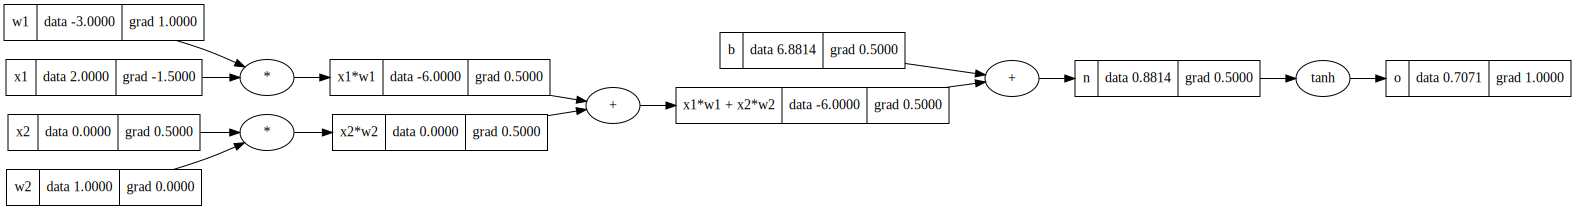

In [ ]:
draw_dot(o)

## 4. Performing backpropogation progmmatically

### 4.1 Implementing the backward function for each operation

* `backward` will perform the chain rule at each node that took inputs and produced outputs -> we will store how we are gonna chain the output's gradient to the input's gradients
  * by default it does nothing, for e.g for a leaf node there is nothing to do -> leaf node is not connected to the operator so not affected
  * backward pass to be performed after the addition has taken place
  * `out.grad` is chained through the local gradient into `self.grad`

In [ ]:
import math

class Value:
  def __init__(self, data, _children = (), _op = '', label = ''): # 'children' is originally a Tuple here
    self.data = data
    self.grad = 0.0 # initially 0
    self._backward = lambda: None # by default does nothing
    self._prev = set(_children) # converted to a set to maintain efficiency
    self._op = _op
    self.label = label

  # Providing a way for the expression to be printed out cleanly
  def __repr__(self):
    return f"Value(data = {self.data})"

  # Python can't add 2 Value's objects so we have to define it ('a+b' won't work)
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = (other.data) * out.grad
      other.grad = (self.data) * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c) = a*b + c
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L' # output of our graph
L

Value(data = -8.0)

In [ ]:
# inputs x1,x2 (2D neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2 (synaptics strings for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'


In [ ]:
o.grad = 1.0
o._backward() # -> calling `self.grad = (1 - t**2) * out.grad`
n._backward()
b._backward() # nothing happens since it's a leaf node ie. not connected to operation
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

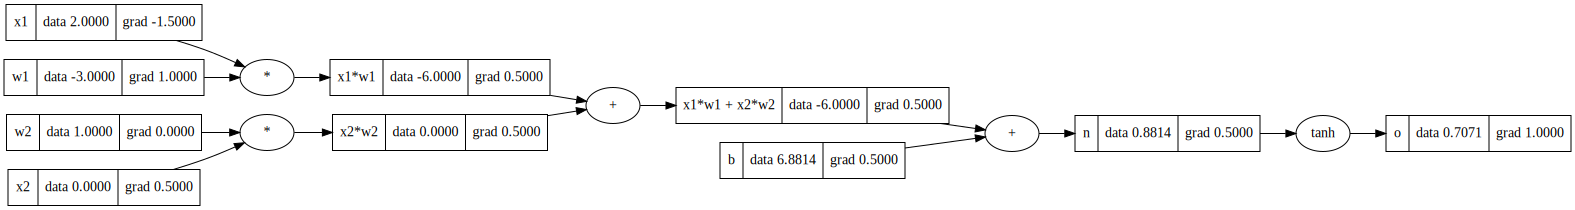

In [ ]:
draw_dot(o)

### 4.2 Implementing the backward function for a whole expression graph

* We've laid out a mathematical expression, and we're trying to go backwards through that expression
* We don't want to call `._backward()` for any node before we've done everything after it, all of its dependencies have to propogate through it before we can continue back propogation
* This ordering of graphs can be achieved using something called **top logical sort**
* **top logical sort** is a laying out of a graph such that all the edges only go from left to right (one way)
  * keeps track of nodes that have been visited
  * starts from a root node and goes through all of its children, and we need to lay them out from left to right
  * after iterating through all of its children and calling top logical on them, it adds itself to the topo list after all the children have been processed
  * this function guarantees that you are only gonna be in the list once all your children are in the list
  * calling `._backward()` on all of the nodes in a top logical order

In [ ]:
# Builds a top logical graph

topo = []
visited = set() # nodes that have been visited
def build_topo(v):
  if v not in visited:
    visited.add(v) # if not visited before, it marks as visited
    for child in v._prev: # iterates through all of its children and calls top logical on them
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data = 1.0),
 Value(data = 0.0),
 Value(data = 0.0),
 Value(data = 2.0),
 Value(data = -3.0),
 Value(data = -6.0),
 Value(data = -6.0),
 Value(data = 6.881373587019543),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

In [ ]:
import math

class Value:
  def __init__(self, data, _children = (), _op = '', label = ''): # 'children' is originally a Tuple here
    self.data = data
    self.grad = 0.0 # initially 0
    self._backward = lambda: None # by default does nothing
    self._prev = set(_children) # converted to a set to maintain efficiency
    self._op = _op
    self.label = label

  # Providing a way for the expression to be printed out cleanly
  def __repr__(self):
    return f"Value(data = {self.data})"

  # Python can't add 2 Value's objects so we have to define it ('a+b' won't work)
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += (other.data) * out.grad
      other.grad += (self.data) * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set() # nodes that have been visited
    def build_topo(v):
      if v not in visited:
        visited.add(v) # if not visited before, it marks as visited
        for child in v._prev: # iterates through all of its children and calls top logical on them
          build_topo(child)
        topo.append(v)
    build_topo(o)
    topo

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c) = a*b + c
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L' # output of our graph
L

Value(data = -8.0)

In [ ]:
# inputs x1,x2 (2D neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2 (synaptics strings for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [ ]:
o.backward()
# o = tanh(n)
# do/dn = 1 - 0**2

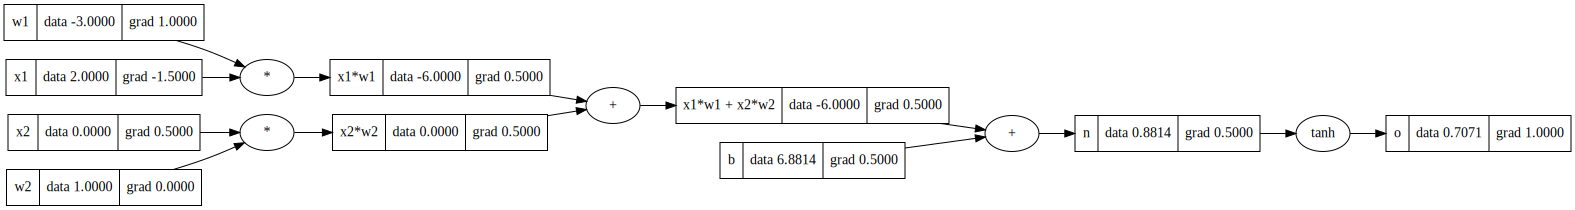

In [ ]:
draw_dot(o)

### 4.3 A bug



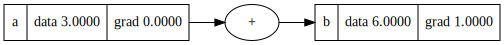

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

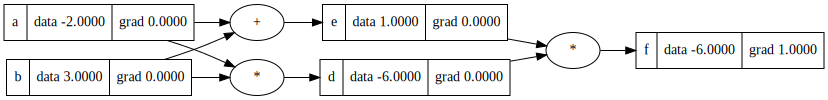

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

## 5. Breaking up `tanh` with more operations

* we can break `tanh` down into other expressions to make more operations occur.
  * ```
    e = (2*n).exp()
    o = (e - 1)/(e + 1)
    ```
* you can't add an integer, or any other data type to a Value object as it has no attribute `data` -> added a line of code to function `add` or `mul` which manipulates `other` to accept data type values with no attribute `data`.
* `other = other if isinstance(other, Value) else Value(other)` when added to these operational functions allowes `(a * 2)` for example to occue, but does not allow `(2 * a)` to occur
  * This is because `(a * 2)` results in a._mul_2 but `(2 * a)` results in 2._mul_a which can't occue due to `a` being a Value object.
  * You can define `rmul()` which is kind of a fallback, it will check if by any chance `(a * 2)` can be done when `(2 * a)` is called -> swaps the operants.


redefining division:
```
a / b
a * (1/b)
a * (b**-1)
```

In [ ]:
import math

class Value:
  """ stores a single scalar value and its gradient """

  def __init__(self, data, _children = (), _op = '', label = ''): # 'children' is originally a Tuple here
    self.data = data
    self.grad = 0.0 # initially 0
    self._backward = lambda: None # by default does nothing
    self._prev = set(_children) # converted to a set to maintain efficiency
    self._op = _op
    self.label = label

  # Providing a way for the expression to be printed out cleanly
  def __repr__(self):
    return f"Value(data = {self.data})"

  # Python can't add 2 Value's objects so we have to define it ('a+b' won't work)
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += (other.data) * out.grad
      other.grad += (self.data) * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad # power rule derivative
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def tanh(self):
        x = self.data
        t = math.tanh(x)  # Use the numerically stable tanh from the math library
        out = Value(t, (self,), 'tanh')

        def _backward():
            # Derivative of tanh(x) is 1 - tanh(x)^2
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # chain rule with exp(x)
    out._backward = _backward

    return out

  def backward(self):
    # Topological sorting to ensure correct order of backpropagation
    topo = []
    visited = set()

    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)  # start from the current tensor
    self.grad = 1.0  # usually, gradient of the loss with respect to itself is 1

    # Backpropagate through the computational graph in reverse topological order
    for node in reversed(topo):
        node._backward()


In [ ]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data = -2.0)

In [ ]:
# inputs x1,x2 (2D neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2 (synaptics strings for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

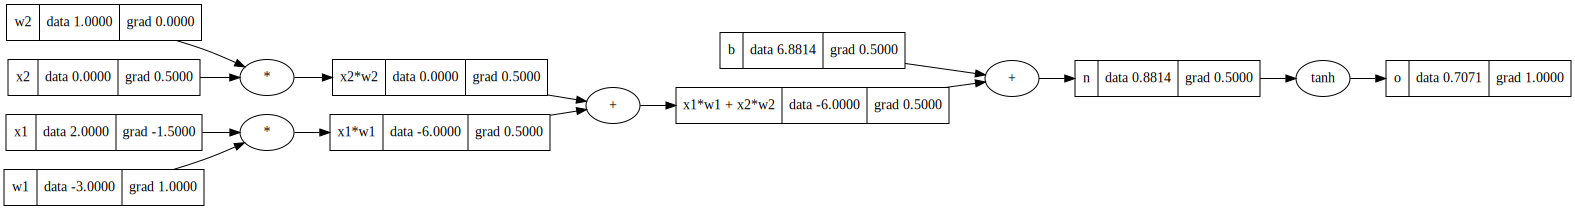

In [ ]:
draw_dot(o)

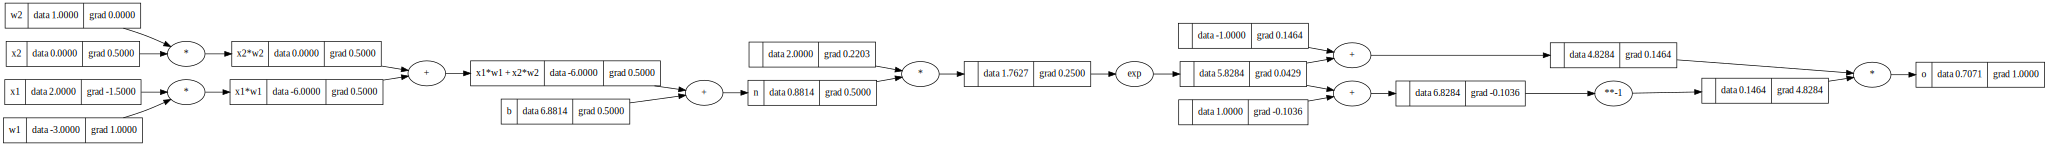

In [ ]:
# inputs x1,x2 (2D neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2 (synaptics strings for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---- Breaking `tanh`
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

### 5.1 Using PyTorch API

* We can do this with PyTorch when your elements are all single element tensors -> everything is more efficient with PyTorch because of tensors.
* `x1`, `x2`, `w1`, `w2`, `b`: These are tensors representing inputs, weights, and bias in a simple neural network.
* `requires_grad = True`: This is set to ensure that PyTorch tracks operations on these tensors so that gradients can be computed during backpropagation as by default PyTorch doesn't track gradients of leaf nodes for efficiency reasons in the most common cases.
* Forward pass (`n = x1 * w1 + x2 * w2 + b`): This calculates the linear combination of inputs and weights plus the bias.
* Activation Function (`o = torch.tanh(n)`): Applies the hyperbolic tangent activation function to the result n.
* `o.backward()`: This call computes the gradients of o with respect to each tensor that has `requires_grad=True`.
* Gradient Outputs: The gradients of `o` with respect to `x1`, `x2`, `w1`, and `w2` are printed.
* we need to call `.item()` as it takes a single tensor of that element, and returns that element


In [ ]:
import torch

# Define the tensors and set requires_grad=True for automatic differentiation
x1 = torch.Tensor([2.0]).double()   # Input x1
x2 = torch.Tensor([0.0]).double()   # Input x2
w1 = torch.Tensor([-3.0]).double()  # Weight w1
w2 = torch.Tensor([1.0]).double()   # Weight w2
b = torch.Tensor([6.8813735870195432]).double()  # Bias term b

# Enable gradients
x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

# Define the computation (forward pass)
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

# Output the result
print(o.data.item()) # we need to call .item() as it takes a single tensor of that element, and returns that element

# Perform backpropagation to calculate gradients
o.backward()

# Print the gradients for each tensor
print('---')
print('x2\'s gradient:', x2.grad.item())
print('w2\'s gradient:', w2.grad.item())
print('x1\'s gradient:', x1.grad.item())
print('w1\'s gradient:', w1.grad.item())
o # or use `o.item()` to get just the value -> 0.7071

0.7071066904050358
---
x2's gradient: 0.5000001283844369
w2's gradient: 0.0
x1's gradient: -1.5000003851533106
w1's gradient: 1.0000002567688737


tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

## 6. Building out a neural net (multi-layer perceptron)

* Neural nets are just a specific class of mathematical expressions
* We will build it piece by piece eventually building a two multi-layer perceptron
* `nin` number of inputs into a neuron
* `zip` takes 2 iterators and it creates a new iterators that iterates of the tuples of the corresponding entries.
* `nout` -> number of neurons in a single layer
* `nouts` -> list of nouts, and this list defines all the sizes of the layers we want in our MLP
* `n = MLP(3, [4, 4, 1])` -> forward pass for an MLP because 4 hidden units in each hidden layer, and one output neuron with 3 input neurons.

In [ ]:
from random import uniform

class Neuron:
    def __init__(self, nin):
        # Initialize weights and bias with random values between -1 and 1
        self.w = [Value(uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(uniform(-1, 1))

    def __call__(self, x):
        # Compute the weighted sum and add the bias -> w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        # Apply the tanh activation function
        out = act.tanh()
        return out

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] # intializing new neurons with this dimensionality

  def __call__(self, x):
    outs = [n(x) for n in self.neurons] # independently evaluating the neurons
    return outs[0] if len(outs) == 1 else outs

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))] # iterating over consecutive pairs of these sizes and create objects for them

  def __call__(self, x): # calling them sequentially
    for layer in self.layers:
      x = layer(x)
    return x


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = 0.8859846989983275)

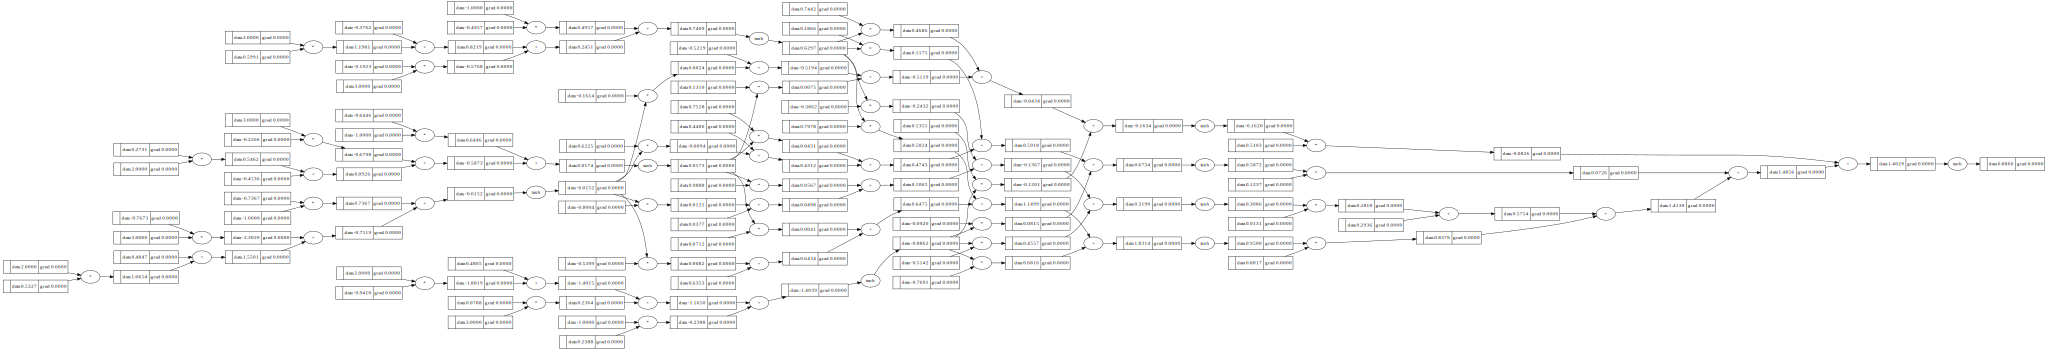

In [ ]:
draw_dot(n(x))

### 6.1 Creating a tiny dataset + writing the loss function + collecting all of the parameters of the neural net

* binary classified neural net
* trick to get desired targets (`ys`) in neural networks is to calculate a single number that somehow measures the total performance of the neural not -> called **loss**.
* loss function:
  * we are pairing up the `ygt` with the predictions, and the zip iterates the tuple of them, and for each `ygt` and `yout` we will subtract them and square them.
  * loss will only be 0 when `ygt` == `yout`.
  * higher the loss, the greater off we are.
* we think of gradient as a vector pointing in the direction of increased loss.
  * making the small step in our gradient descent will make the loss increase while the data decreases, hence we keep **-0.01** as the step.
  * we actually want to decrease the loss, so we go in the opposite direction of the gradient.
  * if you make too big of a step, you might over step the limit as we don't actually know about the loss function. The loss function is all kinds of structure, and we know only about the local dependence of these parameters on the loss

In [ ]:
# draw_dot(loss)

In [ ]:
from random import uniform
import random
# from micrograd.engine import Value

class Neuron:
    def __init__(self, nin):
        # Initialize weights and bias with random values between -1 and 1
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # Compute the weighted sum and add the bias -> w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        # Apply the tanh activation function
        out = act.tanh()
        return out

    def parameters(self): # returns parameters scalars
      return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] # intializing new neurons with this dimensionality

  def __call__(self, x):
    outs = [n(x) for n in self.neurons] # independently evaluating the neurons
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # identical to this:
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))] # iterating over consecutive pairs of these sizes and create objects for them

  def __call__(self, x): # calling them sequentially
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = 0.9647122491794248)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [ ]:
# Assuming 'n' is a function that produces TensorFlow Tensors
import tensorflow as tf

# loss function using Value objects
for k in range(30):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # have to zero.grad() to reset them after the forward pass for the backward pass
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad # tiny upgrade in our gradient descent scheme with a small step

  print(k, loss.data)

0 5.615762112747694
1 3.2605108519210284
2 1.4189575608777107
3 0.5241496077388398
4 0.30162763584196595
5 0.20793890920083147
6 0.1609832800888561
7 0.1307603731505176
8 0.10976564904395844
9 0.09437707816761987
10 0.08263862892559426
11 0.073404212843214
12 0.06595922442538879
13 0.059835682866855595
14 0.05471468576172441
15 0.050371652784413606
16 0.046643990506154795
17 0.043411170982598724
18 0.04058200873947435
19 0.03808627970470532
20 0.03586904973273647
21 0.03388674496275943
22 0.032104371520661965
23 0.030493511387911718
24 0.029030853389899122
25 0.027697100046931097
26 0.02647614290695608
27 0.025354432611096232
28 0.024320492185306346
29 0.023364537030290195


In [ ]:
ypred

[Value(data = 0.9640842599602847),
 Value(data = -0.966101322650361),
 Value(data = -0.8885761268967528),
 Value(data = 0.9077492719578522)]

## Summary

* What are neural nets?
  * Are mathematical expressions in case of Multi-layer perceptron that take input as the data, and take weights and paramteres and the neural net
  * mathematical expressions in the forward pass, and the loss function tries to measure the accuracy, and loss will usually be low when your predictions match your targets -> behaving well
  * we manipulate the loss function so when loss is low, the network is behaving well
  * we use back propogation to get the gradient and then we tune the parameters to decrease the loss locally, but then we have to operate the process multiple times in what is called the gradient descent
  * this neural net has only 41 parameters and many more complex neural nets can be built which have very beautiful properties

* `tanh` used instead of `ReLU` as it is more complex and smoother therefore it is stressed a little bit more on the local gradients and derivatives which is useful for our neural net.